In [0]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
from scipy.stats import uniform #for training and test splits
from scipy.stats import gaussian_kde as kde # for resampling dataset
from scipy import stats #
import statsmodels.formula.api as smf #R-like model specification
import matplotlib.pyplot as plt #2D plotting
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns #

import warnings
import timeit # for performance debugging
import logging

# set global properties
dataDir = './data/'
configDir = './config/'
logOutDir = './log/'
imageDir = './images/'
modelBaselineDir = './models/baseline/'
modelImprovedDir = './models/improved/'
#loggerConfig = 'loggerConfig.yaml'
loglevel = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

# get a logger for troubleshooting / data exploration
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# read in datasets
import pickle
# look for reduced memory dataset first
isMemoryReductionTrain = False
isMemoryReductionTest = False

# training datasets # VESTA
v_train_identity = pd.read_csv('/content/drive/My Drive/IST718/train_identity.csv')
v_train_transaction = pd.read_csv('/content/drive/My Drive/IST718/train_transaction.csv')

# merge VESTA training datasets
v_train = pd.merge(v_train_transaction, v_train_identity, on='TransactionID', how='left') 

# free up memory of loaded datasets after merging
v_train_identity = None
v_train_transaction = None

# testing datasets
v_test_identity = pd.read_csv('/content/drive/My Drive/IST718/test_identity.csv')
v_test_transaction = pd.read_csv('/content/drive/My Drive/IST718/test_transaction.csv')

# merge test datasets
v_test = pd.merge(v_test_transaction, v_test_identity, on='TransactionID', how='left')
    
# free up memory of loaded datasets after merging
v_test_identity = None
v_test_transaction = None


In [4]:
# perform exploratory data analysis techiques
print(v_train.head())
print(v_test.head())

   TransactionID  isFraud  ...  DeviceType                     DeviceInfo
0        2987000        0  ...         NaN                            NaN
1        2987001        0  ...         NaN                            NaN
2        2987002        0  ...         NaN                            NaN
3        2987003        0  ...         NaN                            NaN
4        2987004        0  ...      mobile  SAMSUNG SM-G892A Build/NRD90M

[5 rows x 434 columns]
   TransactionID  TransactionDT  TransactionAmt  ... id_38  DeviceType  DeviceInfo
0        3663549       18403224           31.95  ...   NaN         NaN         NaN
1        3663550       18403263           49.00  ...   NaN         NaN         NaN
2        3663551       18403310          171.00  ...   NaN         NaN         NaN
3        3663552       18403310          284.95  ...   NaN         NaN         NaN
4        3663553       18403317           67.95  ...   NaN         NaN         NaN

[5 rows x 433 columns]


In [0]:
americanexpress = v_train[v_train['card4'] == 'american express']
mastercard = v_train[v_train['card4'] == 'mastercard']
visa = v_train[v_train['card4'] == 'visa']
mobile = v_train[v_train['DeviceType'] == 'mobile']
desktop = v_train[v_train['DeviceType'] == 'desktop']
debit = v_train[v_train['card6'] == 'debit']
credit = v_train[v_train['card6'] == 'credit']

ordered_card_names = ['American Express', 'Mastercard', 'Visa']
ordered_card_type = ['Debit', 'Credit']
ordered_device_type = ['Mobile', 'Desktop']

In [0]:
data1 = [americanexpress['TransactionAmt'], mastercard['TransactionAmt'], 
    visa['TransactionAmt']]
data2 = [mobile['TransactionAmt'], desktop['TransactionAmt']]
data3 = [debit['TransactionAmt'], credit['TransactionAmt']]

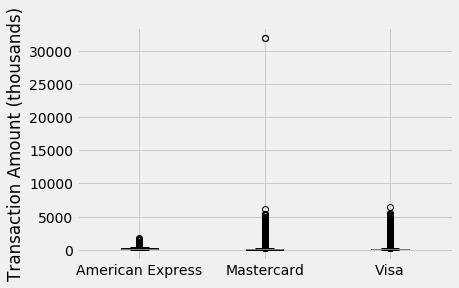

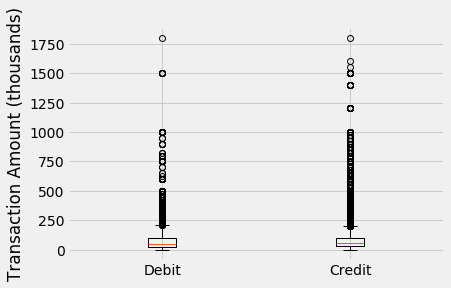

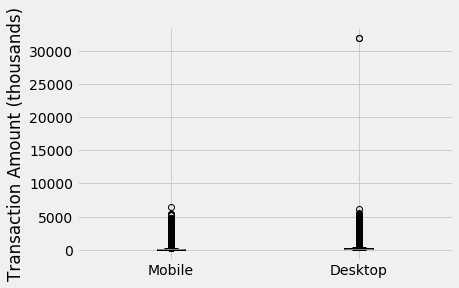

In [7]:
fig, axis = plt.subplots()
axis.set_ylabel('Transaction Amount (thousands)')
day_plot = plt.boxplot(data1, sym='o', vert=1, whis=1.5)
plt.setp(day_plot['boxes'], color = 'black')    
plt.setp(day_plot['whiskers'], color = 'black')    
plt.setp(day_plot['fliers'], color = 'black', marker = 'o')
axis.set_xticklabels(ordered_card_names)
plt.show()

fig, axis = plt.subplots()
axis.set_ylabel('Transaction Amount (thousands)')
day_plot = plt.boxplot(data2, sym='o', vert=1, whis=1.5)
plt.setp(day_plot['boxes'], color = 'black')    
plt.setp(day_plot['whiskers'], color = 'black')    
plt.setp(day_plot['fliers'], color = 'black', marker = 'o')
axis.set_xticklabels(ordered_card_type)
plt.show()

fig, axis = plt.subplots()
axis.set_ylabel('Transaction Amount (thousands)')
day_plot = plt.boxplot(data3, sym='o', vert=1, whis=1.5)
plt.setp(day_plot['boxes'], color = 'black')    
plt.setp(day_plot['whiskers'], color = 'black')    
plt.setp(day_plot['fliers'], color = 'black', marker = 'o')
axis.set_xticklabels(ordered_device_type)
plt.show()

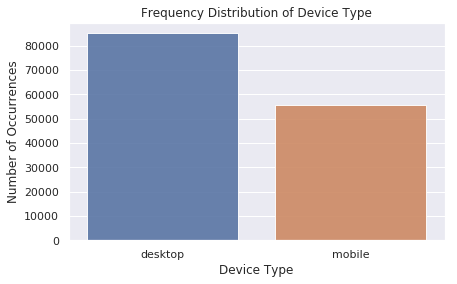

In [8]:
#basic bar of device type
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
counts = v_train['DeviceType'].value_counts()
sns.set(style="darkgrid")
sns.barplot(counts.index, counts.values, alpha=0.9)
plt.title('Frequency Distribution of Device Type')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Device Type', fontsize=12)
plt.show()

## Clustering Analysis

In [9]:
# examine proportion responding across levels 
# of categorical variables
print(v_train.pivot_table(['isFraud'], index = ['card4']))
print(v_train.pivot_table(['isFraud'], index = ['card6']))
print(v_train.pivot_table(['isFraud'], index = ['DeviceType']))


                   isFraud
card4                     
american express  0.028698
discover          0.077282
mastercard        0.034331
visa              0.034756
                  isFraud
card6                    
charge card      0.000000
credit           0.066785
debit            0.024263
debit or credit  0.000000
             isFraud
DeviceType          
desktop     0.065215
mobile      0.101662


In [10]:
print(v_train["card4"].value_counts())

print(v_train["card6"].value_counts())

print(v_train["DeviceType"].value_counts())

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64
debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64
desktop    85165
mobile     55645
Name: DeviceType, dtype: int64


In [0]:
v_train_min = v_train
v_train_min = v_train[['TransactionID','isFraud','card4','card6',
                                           'DeviceType','TransactionAmt','TransactionDT','P_emaildomain','R_emaildomain']]

# K Means


In [0]:
def handle_non_numerical_data(df):
    columns = df.columns.values

    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df

v_train_min = handle_non_numerical_data(v_train_min)

In [48]:
print(v_train_min.tail())

        TransactionID  isFraud  ...  P_emaildomain  R_emaildomain
590535        3577535        0  ...              0              0
590536        3577536        0  ...             52              0
590537        3577537        0  ...             52              0
590538        3577538        0  ...              6              0
590539        3577539        0  ...             52              0

[5 rows x 9 columns]


In [50]:
from sklearn.cluster import KMeans
X = np.array(v_train_min.drop(['isFraud'], 1).astype(float))
y = np.array(v_train_min['isFraud'])

clf = KMeans(n_clusters=2)
clf.fit(v_train_min)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [51]:
correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(1, len(predict_me))
    prediction = clf.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(v_train_min))

ValueError: ignored

In [52]:
from sklearn import preprocessing
X = np.array(v_train_min.drop(['isFraud'], 1).astype(float))
X = preprocessing.scale(v_train_min)
y = np.array(v_train_min['isFraud'])

clf = KMeans(n_clusters=2)
clf.fit(v_train_min)

correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = clf.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(v_train_min))

0.03499000914417313


In [53]:
X = np.array(v_train_min.drop(['isFraud', 'TransactionDT','P_emaildomain','R_emaildomain'], 1).astype(float))
X = preprocessing.scale(v_train_min)
y = np.array(v_train_min['isFraud'])

clf = KMeans(n_clusters=2)
clf.fit(v_train_min)

correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = clf.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(v_train_min))

0.9650099908558268
